# Basic Usage

**[AutoRA](https://pypi.org/project/autora/)** (**Au**tomated **R**esearch **A**ssistant) is an open-source framework designed to automate various stages of empirical research, including model discovery, experimental design, and data collection.

This notebook provides a comprehensive introduction to the capabilities of ``autora``. **It demonstrates the fundamental components of ``autora``, and how they can be combined to facilitate automated (closed-loop) empirical research through synthetic experiments.**

***How to use this notebook**: You can progress through the notebook section by section or directly navigate to specific sections. If you choose the latter, it is recommended to execute all cells in the notebook initially, allowing you to easily rerun the cells in each section later without issues.*

**<font color="red"> TODO: (o) extend to 2d-function, (o) add BMS seed (o) make smaller pool of conditions so that novel conditions don't overlap as much </font>**

## Overview

1. Installing ``autora``
2. Automated Empirical Research Components
    2.1. Experiment Runners
    2.2. Theorists
    2.3. Experimentalists
3. Automated Empirical Research With Basic Loop Constructs
4. Automated Empirical Research With AutoRA Workflow Logic
    4.1. Basic Workflows
    4.2. Advanced Workflows
5. Customizing Automated Empirical Research Components

## Installation

The AutoRA ecosystem is a comprehensive collection of packages that together establish a framework for closed-loop empirical research. At the core of this framework is the ``autora`` package, which serves as the parent package and is essential for end users to install.  It provides functionalities for automating workflows in empirical research and includes vetted modules with minimal dependencies.

However, the flexibility of autora extends further with the inclusion of *optional* modules as additional dependencies. Users have the freedom to selectively install these modules based on their specific needs and preferences.

<img src="https://autoresearch.github.io/autora/img/package_overview.png" width="75%" alt="AutoRA Package Structure">

*Optional dependencies enable users to customize their autora environment without worrying about conflicts with other packages within the broader autora ecosystem. To install an optional module, simply use the command ``autora[dependency-name]``, where ``dependency-name`` corresponds to the name of the desired module (see example below).*

To begin, we will install all the relevant optional dependencies. Our focus will be on two experimentalists: ``experimentalist-falsification`` and ``experimentalist-sampler-novelty``, along with a Bayesian Machine Scientist (BMS) implemented in the ``theorist-bms`` package. It's important to note that installing a module will automatically include the main autora package, as well as any required dependencies for workflow management and running synthetic experiments.

In [ ]:
!pip install -q "autora[experimentalist-falsification]"
!pip install -q "autora[experimentalist-sampler-novelty]"
!pip install -q "autora[experimentalist-sampler-model-disagreement]"
!pip install -q "autora[theorist-bms]"

^C
ERROR: Operation cancelled by user


## Automated Empirical Research Components

The goal of this section is to set up all ``autora`` components to enable a closed-loop discovery workflow with synthetic data. This involves specifying (1) the experiment environment, (2) a theorist for model discovery, (3) an experimentalist for identifying novel experiment conditions.

<img src="https://github.com/AutoResearch/autora/blob/main/docs/img/modules_overview.png?raw=true" width="75%" alt="AutoRA Components">

### Experiments

``autora`` provides support for experiment runners, which serve as interfaces for conducting both real-world and synthetic experiments. An experiment runner typically accepts experiment conditions as input (e.g., a 2-dimensional numpy array with columns representing different independent variables) and produces collected observations as output (e.g., a 2-dimensional numpy array with columns representing different dependent variables). These experiment runners can be combined with other ``autora`` components to facilitate closed-loop scientific discovery.

<img src="../img/experiment_runner.png" width="75%" alt="AutoRA Components">

#### Types

AutoRA offers two types of experiment runners: **real-world experiments** and **synthetic experiments**.

For **real-world experiments**, experiment runners can include interfaces for various scenarios such as web-based experiments for behavioral data collection (e.g., using [Firebase and Prolific](https://autoresearch.github.io/autora/user-guide/experiment-runners/firebase-prolific/)) or experiments involving electrical circuits (e.g., using [Tinkerforge](https://en.wikipedia.org/wiki/Tinkerforge)). These runners often require external components such as databases to store collected observations or servers to host the experiments. You may refer to the respective tutorials for these interfaces on how to set up all required components.

**Synthetic experiments** are conducted on synthetic experiment runners, which are functions that take experimental conditions as input and generate simulated observations as output. These experiments serve multiple purposes, including *testing autora components* before applying them to real-world experiments, *benchmarking methods for automated scientific discovery*, or *conducting computational metascientific experiments*.

In this introductory tutorial, we primarily focus on simple synthetic experiments. For more complex synthetic experiments implementing various scientific models, you can utilize the[autora-synthetic](https://github.com/autoresearch/autora-synthetic/) module.

#### Usage

To create a synthetic experiment runner, we begin with **defining a ground truth** from which to generate data. Here, we consider a simple sine function:

$y = f(x) = \sin(x)$

In this case, $x$ corresponds to an *independent* variable (the variable we can manipulate in an experiment), $y$ corresponds to a *dependent* variable (the variable we can observe after conducting the experiment), and $f(x)$ is the *ground-truth function* (or "mechanism") that we seek to uncover via a combination of experimentation and model discovery.

However, we assume that observations are obtained with a measurement error when running the experiment.

$\hat{y} = \hat{f}(x) = f(x) + \epsilon, \quad \epsilon \sim \mathcal{N}(0,0.01^{2})$

where $\epsilon$ is the measurement error sampled from a normal distribution with zero mean and a standard deviation of $0.01$.

The following code block defines ground truth $f(x)$ and the experiment runner $\hat{f}(x)$ as ``lambda`` functions.

In [ ]:
ground_truth = lambda x: np.sin(x)
run_experiment = lambda x: ground_truth(x) + np.random.normal(0, 0.1, size=x.shape)

Next, we generate a pool of all possible experimental conditions from the domain $[0, 2\pi]$.

In [ ]:
import numpy as np

condition_pool = np.linspace(0, 2 * np.pi, 1000)

In order to run a simple synthetic experiment, we can first sample from the pool of possible experiment conditions (without replacement), and then pass these conditions to the synthetic experiment runner:

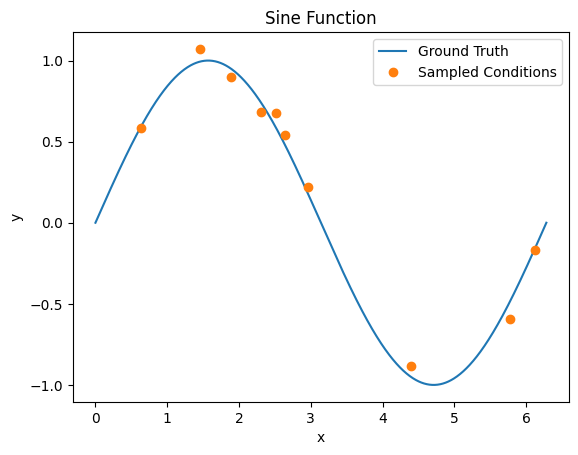

In [ ]:
initial_conditions = np.random.choice(condition_pool, size=10, replace=False)
initial_observations = run_experiment(initial_conditions)

# plot sampled conditions against ground-truth
import matplotlib.pyplot as plt
plt.plot(condition_pool, ground_truth(condition_pool), label='Ground Truth')
plt.plot(initial_conditions, initial_observations, 'o', label='Sampled Conditions')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sine Function')
plt.legend()

Certain theorists and experimentalists may need to have knowledge about the experimental variables, such as the domain from which new experiment conditions are sampled. To provide this information, we can utilize a ``VariableCollection`` object. In the context of our synthetic experiment, we have a single *independent variable* (``IV``) denoted as $x$, and a single *dependent* variable (``DV``) denoted as $y$.

In [ ]:
from autora.variable import DV, IV, ValueType, VariableCollection

# Specify independent variable
iv = IV(
    name="x",                       # name of the independent variable
    value_range=(0, 2 * np.pi),     # specify the domain
    allowed_values=condition_pool,  # alternatively, we can specify the pool of allowed conditions directly
)

# specify dependent variable
dv = DV(
    name="y",                       # name of the dependent variable
    type=ValueType.REAL,            # specify the variable type (some theorists require this to optimize)
)

# Variable collection with ivs and dvs
metadata = VariableCollection(
    independent_variables=[iv],
    dependent_variables=[dv],
)

***Note**: For expository reasons, we focus in this tutorial on simple synthetic experiments. In general, ``autora`` provides functionality for automating [more complex synthetic experiments](https://github.com/autoresearch/autora-synthetic/), as well as real-world experiments, such as [behavioral data collection via web-based experiments](https://autoresearch.github.io/autora/user-guide/experiment-runners/firebase-prolific/), experiments with electrical circuits via [Tinkerforge](https://en.wikipedia.org/wiki/Tinkerforge), and other automated experimentation platforms.*

### Theorists

The AutoRA framework includes and interfaces with different methods for scientific model discovery. These methods are referred to as *theorists* and are implemented as [sklearn estimators](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html). For general information about theorists, see the respective [AutoRA Documentation](https://autoresearch.github.io/autora/theorist/).

<img src="https://autoresearch.github.io/autora/img/theorist.png" width="75%" alt="Theorist Overview">


Theorists **take as input a set of conditions and observations**. Conditions and observations can typically be passed as *two-dimensional numpy arrays* (with columns corresponding to variables and rows corresponding to different instances of those variables). Theorists then **identify and fit a model** which may be used to predict observations based on experiment conditions.

#### Types

There are different types of theorists within the AutoRA framework, each with its own approach to scientific model discovery.

Some theorists focus on *fitting the parameters of a pre-specified model* to the given data (see the scikit learn documentation for a [selection of basic regressors](https://scikit-learn.org/stable/supervised_learning.html)). The model architecture in such cases is typically fixed, while the parameters are adjusted to optimize the model's performance. Linear regression is an example of a parameter-fitting theorist.

Other theorists are concerned with *identifying both the architecture of a model and its parameters*. The model architectures can take various forms, such as equations, causal models, or process models. Implemented as scikit-learn estimators, these theorists aim to discover a model architecture that accurately describes the data. They often operate within a user-defined search space, which specifies the allowable operations or components that can be included in the model. This approach provides more flexibility in exploring different model architectures.

#### Usage

In this tutorial, we delve into two types of theorists: (1) a linear regression theorist, which focuses on fitting a linear model, and (2) a Bayesian Machine Scientist (Guimerà et al., 2020, in *Science Advances*), which specializes in identifying and fitting a non-linear equation.

Theorists are commonly instantiated as regressors within the ``sklearn`` library:

In [ ]:
from sklearn import linear_model
from autora.theorist.bms import BMSRegressor

theorist_lr = linear_model.LinearRegression()
theorist_bms = BMSRegressor(epochs=100)

Once instantiated, we can fit the theorist to link experimental conditions with observations. However, before doing so, we should convert both inputs into 2-dimensional numpy arrays.

In [ ]:
# convert data to 2-dimensional numpy array
initial_conditions = initial_conditions.reshape((len(initial_conditions), 1))
initial_observations = initial_observations.reshape((len(initial_observations), 1))

# fit theorists
theorist_lr.fit(initial_conditions, initial_observations)
theorist_bms.fit(initial_conditions, initial_observations)

INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:07<00:00, 13.80it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


BMSRegressor(epochs=100)

For some theorists, we can inspect the resulting model architecture. For instance, in the BMS theorist, we can call obtain the model formula via ``theorist_bms.model_.__repr__()``.

In [ ]:
print("Model of BMS theorist: " + theorist_bms.model_.__repr__())

Model of BMS theorist: sin(X0)


We may now obtain predictions from both theorists for the entire pool of experiment conditions.

In [ ]:
# convert condition pool into 2-dimensional numpy array before generating respective predictions
condition_pool = condition_pool.reshape((len(condition_pool), 1))

# obtain predictions
predicted_observations_lr = theorist_lr.predict(condition_pool)
predicted_observations_bms = theorist_bms.predict(condition_pool)

In the next code segment, we plot the theorists' predictions against the ground truth. For the BMS theorist, we can obtain a latex expression of the model architecture using ``theorist_bms.model_.latex()``.

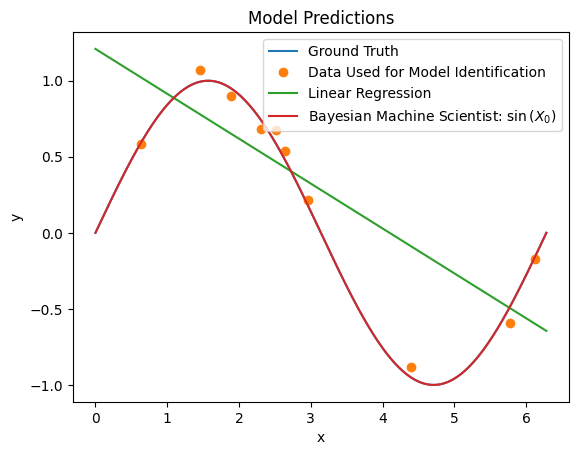

In [ ]:
# obtain latex expression of BMS theorist
bms_model = theorist_bms.model_.latex()

# plot model predictions against ground-truth
import matplotlib.pyplot as plt
plt.plot(condition_pool, ground_truth(condition_pool), label='Ground Truth')
plt.plot(initial_conditions, initial_observations, 'o', label='Data Used for Model Identification')
plt.plot(condition_pool, predicted_observations_lr, label='Linear Regression')
plt.plot(condition_pool, predicted_observations_bms, label='Bayesian Machine Scientist: $' + bms_model + '$')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Model Predictions')
plt.legend()

***Note**: that there are various other types of theorists you can combine with AutoRA as long as they are implemented as ``sklearn`` estimators. This includes [autora modules](theorist/index.md), any [scikit learn estimators](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html), as well as third-party packages, such as [PySR](https://github.com/MilesCranmer/PySR) for symbolic regression.*

### Experimentalists

The primary goal of an experimentalist is to design experiments that yield scientific merit. The AutoRA framework offers various strategies for identifying informative new data points (e.g., by searching for experiment conditions that existing scientific models fail to explain, or by looking for novel conditions altogether).

<img src="https://autoresearch.github.io/autora/img/experimentalist.png" width="75%" alt="Experimentalist Overview">

Experimentalists are implemented as functions that return a set of experiment conditions (e.g., in the form of a 2-dimensional numpy array in which columns correspond to independent variables), which can be subjected to an experiment. To determine these conditions, experimentalists may use information about candidate models obtained from a theorist, experimental conditions that have already been probed, or respective dependent measures. For more detailed information about experimentalists, please refer to the corresponding [AutoRA Documentation](https://autoresearch.github.io/autora/experimentalist/).

#### Types

There are generally three types of experimentalist functions: **poolers**, **samplers**, and **pipelines**.

**Poolers** generate a novel set of experimental conditions "from scratch", e.g., by sampling from a grid. They usually require metadata describing independent variables of the experiment (e.g., their range or the set of allowed values).

**Samplers** operate on an existing pool of experimental conditions. They require typically require experimental conditions to be represented as a 2-dimensional numpy array in which columns correspond to independent variables and rows to different conditions). They then select experiment conditions from this pool.

**Pipelines** Pipelines connect multiple experimentalists into a unified workflow. This is beneficial when various steps are required to process experiment conditions. For example, apart from identifying novel experimental conditions, experimentalist functions may perform other operations on the set of conditions, such as rearranging the rows of a condition matrix or adding new experiment conditions as columns. Experiment pipelines may begin with a pooler that generates all possible experiment conditions, followed by a sampler that selects a subset of conditions from the pool, and then proceed to additional functions that arrange the selected conditions in a specific order necessary for conducting the experiment.

#### Usage: Poolers

Experimentalist poolers are implemented as functions and can be called directly. For instance, the following **grid pooler** generates a grid based on the ``allowed_values`` of all independent variables in the ``metadata`` object that we defined above. We can simply add a list of allowed values to each independent variable. In this case, we only have one variable.

In [ ]:
allowed_values = np.linspace(0, 2 * np.pi, 1000)
metadata.independent_variables[0].allowed_values = allowed_values

Now we can pass the grid pooler the list of independent variables from the ``metadata`` object.

In [ ]:
from autora.experimentalist.pooler.grid import grid_pool

new_conditions = grid_pool(ivs = metadata.independent_variables)

The resulting condition pool contains all experiment conditions from the grid:

In [ ]:
# return first 10 conditions
for idx, condition in enumerate(new_conditions):
    print(condition)
    if idx > 9:
        break

(0.0,)
(0.006289474781961547,)
(0.012578949563923095,)
(0.018868424345884642,)
(0.02515789912784619,)
(0.03144737390980774,)
(0.037736848691769284,)
(0.04402632347373083,)
(0.05031579825569238,)
(0.056605273037653926,)
(0.06289474781961547,)


Alternatively, we may use the **random pooler** to randomly draw experimental conditions from the domains of each independent variable. The random pooler requires as input a list of discrete values from which to sample from. In this case, we can pass it ``metadata.independent_variables[0].allowed_values`` for the independent variable. We can also specify the input argument ``n`` to obtain 10 random samples.

In [ ]:
from autora.experimentalist.pooler.random_pooler import random_pool

# generate random pool of 10 conditions
num_samples = 10
new_conditions = random_pool(metadata.independent_variables[0].allowed_values,
                             n=num_samples)

# print conditons
for idx, condition in enumerate(new_conditions):
    print(condition)

(1.723316090257464,)
(5.924685244607778,)
(0.918263318166386,)
(4.006395436109505,)
(0.4780000834290776,)
(2.4528951649650033,)
(1.4528686746331174,)
(0.4528421843012314,)
(2.792526803190927,)
(5.905816820261893,)


#### Usage: Samplers

An experiment sampler typically requires an existing pool of conditions as input along with additional arguments. For instance, the **[novelty sampler](https://autoresearch.github.io/autora/user-guide/experimentalists/samplers/novelty/)** requires, aside from a pool of conditions, a list of prior conditions. The user may also specify the number of samples ``num_samples`` to select from the pool.

The novelty sampler will then select novel experiment conditions from the pool which are most dissimilar to some reference conditions, such as the ``initial_conditions`` obtained above:

In [ ]:
from autora.experimentalist.sampler.novelty import novelty_sample

new_conditions_novelty = novelty_sample(condition_pool = condition_pool,
                                 reference_conditions = initial_conditions,
                                 num_samples = 2)

print(new_conditions_novelty)

[[3.68563222]
 [3.67934275]]


Another example for an experiment sampler is the **[falsification sampler](https://autoresearch.github.io/autora/falsification/docs/sampler/)**. The falsification sampler identifies experiment conditions under which the loss of a candidate model (returned by the theorist) is predicted to be the highest. This loss is approximated with a neural network, which is trained to predict the loss of the candidate model, given some initial experimental conditions, respective initial observations, and the metadata.

The following code segment calls on the falsification sampler to return novel conditions based on the candidate model of the BMS theorist introduced above. As with the novelty sampler, we seek to select 10 conditions.

In [ ]:
from autora.experimentalist.sampler.falsification import falsification_sample

new_conditions_falsification = falsification_sample(
        condition_pool=condition_pool,
        model=theorist_bms,
        reference_conditions=initial_conditions,
        reference_observations=initial_observations,
        metadata=metadata,
        num_samples=2
    )

print(new_conditions_falsification)

[[5.13221142]
 [5.1385009 ]]


We can plot the selected conditions for both samples relative to the selected samples. Since we don't have observations for those conditions, we plot them as vertical lines.

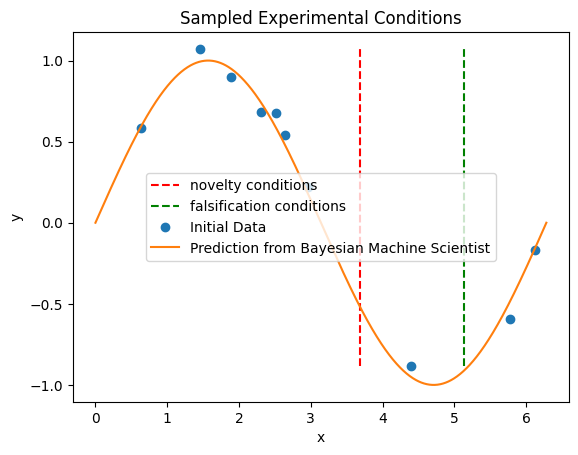

In [ ]:
# plot model predictions against ground-truth
import matplotlib.pyplot as plt

y_min = np.min(initial_observations)
y_max  = np.max(initial_observations)

# plot conditions obtained by novelty sampler
for idx, condition in enumerate(new_conditions_novelty):
    if idx == 0:
        plt.plot([condition[0], condition[0]], [y_min, y_max], '--r', label='novelty conditions')
    else: # we want to omit the label for all other conditions
        plt.plot()

# plot conditions obtained by falsification sampler
for idx, condition in enumerate(new_conditions_falsification):
    if idx == 0:
        plt.plot([condition[0], condition[0]], [y_min, y_max], '--g', label='falsification conditions')
    else: # we want to omit the label for all other conditions
        plt.plot()

plt.plot(initial_conditions, initial_observations, 'o', label='Initial Data')
plt.plot(condition_pool, predicted_observations_bms, label='Prediction from Bayesian Machine Scientist')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sampled Experimental Conditions')
plt.legend()


#### Usage: Pipelines

Experimentalists can be connected in a **[pipeline](https://autoresearch.github.io/autora/core/docs/pipeline/Experimentalist%20Pipeline%20Examples/)**, where each element passes its output to the next element, ensuring compatibility between the inputs and outputs. Pipelines offer a flexible and efficient way to orchestrate the workflow involving complex experimentalists (e.g., for processing of experimental conditions) and experiment runners (e.g., for preprocessing of collected observations). They allow for the integration of poolers, samplers, and other design manipulations into a cohesive stream of experimental conditions.

Let's examine the following pipeline example:

<ol>
<li> Generate a grid of all possible experimental conditions.
<li> Filter out conditions where the independent variable falls within the range -1 to 1.
<li> Sample 100 conditions using the novelty sampler.
<li> Select 5 conditions from the sampled set using the falsification sampler.
</ol>

Before creating the pipeline, let's define an additional function that removes experiment conditions falling within the range of -1 to 1, specifically $-1 \leq x \leq 1$. This function will be used in the second step of the pipeline.

In [ ]:
from typing import Iterable

def condition_exclusion(conditions):
    # first we need to make sure that conditions is a 2-dimensional numpy array
    if isinstance(conditions, Iterable):
        conditions = np.array(list(conditions))

    if conditions.ndim == 1:
        conditions = conditions.reshape(-1, 1)

    # now we can sub-select conditions
    conditions_to_keep = conditions[(-1 > conditions) | (conditions > 1)]
    conditions_to_keep = conditions_to_keep.reshape(-1, 1)
    return conditions_to_keep

A pipeline can be defined as a list of functions, such as ``[grid_pool, value_exclusion, novelty_sample, falsification_sample]``. However, to create a pipeline object, we need to specify the required parameters for each element in the pipeline. We can achieve this by providing nested dictionaries containing the additional parameters, as shown in the code block below.

***Note**: Each element of the pipeline passes its output to the next element as the first argument of the element's function. Thus, we need to make sure that the output of one pipeline element is compatible with the required first input argument for the next element. In our case, the first argument for each pipeline element (except for poolers) is assumed to be a 2-dimensional numpy array specifying a set of experimental conditions.*


In [ ]:
from autora.experimentalist.pipeline import make_pipeline

experimentalist_pipeline = make_pipeline([grid_pool,
                                 condition_exclusion,
                                 novelty_sample,
                                 falsification_sample],
                                params={"grid_pool":
                                            {"ivs": metadata.independent_variables},
                                        "novelty_sample":
                                            {"reference_conditions": initial_conditions,
                                             "num_samples": 100},
                                        "falsification_sample":
                                            {"model": theorist_bms,
                                             "reference_conditions": initial_conditions,
                                             "reference_observations": initial_observations,
                                             "metadata": metadata,
                                             "num_samples": 10}})

In the declaration of the ``params`` parameter, we first specify the name of the pipeline object we seek to parameterize as a dictionary key, e.g., ``"grid_pool"``, and then nest within it, another dictionary with the names of the input arguments as keys (e.g., ``"ivs"``) along with their values (e.g.,  ``metadata.independent_variables``).

Once specified, we can run the pipeline object to obtain novel experimental conditions.

In [ ]:
new_conditions = experimentalist_pipeline.run()

print(new_conditions)

[[4.94981665]
 [4.95610613]
 [4.9623956 ]
 [4.96868508]
 [4.97497455]
 [4.98126403]
 [4.9875535 ]
 [4.99384298]
 [5.00013245]
 [5.00642193]]


***Hint**: A common error for running pipelines is that the output of one pipeline element is incompatible with the input of the next pipeline element (e.g., not providing a 2-dimensional numpy array to ``novelty_sample``). In such cases, it can be helpful to "manually" pass the inputs from one element to another element, to check if they are compatible.*

***Note**: Pipelines may be used for other purposes, such as linking an experiment runner with multiple pre-processing steps.*

## Automated Empirical Research With Basic Loop Constructs

After defining all the components required for the empirical research process, we can create an automated workflow using basic loop constructs in Python.

The following code block demonstrates how to build such a workflow using the components introduced in the preceding sections, such as

- ``metadata`` (object specifying variables of the experiment), <br>
- ``run_experiment`` (function for collecting data), <br>
- ``theorist_bms`` (scikit learn estimator for discoverying requations using the Bayesian Machine Scientist), <br>
- ``random_pool`` (function for generating a random pool of experimental conditions), and <br>
- ``falsification_sample`` (function for identifying novel experiment conditions using the falsification .sampler) <br>

We begin with implementing the following workflow:
1. Generate 10 seed experimental conditions using ``random_pool``
2. Generate 10 seed observations using ``run_experiment``
3. Loop through the following steps 5 times
   2.1. Identify a model relating conditions to observations using ``theorist_bms``
   2.2. Identify 10 new experimental conditions using ``falsification_sample``
   2.3. Collect 10 new observations using ``run_experiment``
   2.4  Add new conditions and observations to the dataset

In [ ]:
num_cycles = 3 # number of empirical research cycles
measurements_per_cycle = 10 # number of data points to collect for each cycle

# generate an initial set of 10 experimental conditions
conditions = random_pool(metadata.independent_variables[0].allowed_values,
                                 n=measurements_per_cycle)
# convert iterator into 2-dimensional numpy array
conditions = np.array(list(conditions)).reshape(-1, 1)

# collect initial set of observations
observations = run_experiment(conditions)

for cycle in range(num_cycles):

  # use BMS theorist to fit the model to the data
  theorist_bms.fit(conditions, observations)

  # obtain new conditions
  new_conditions = falsification_sample(
          condition_pool=condition_pool,
          model=theorist_bms,
          reference_conditions=conditions,
          reference_observations=observations,
          metadata=metadata,
          num_samples=measurements_per_cycle,
      )

  # obtain new observations
  new_observations = run_experiment(new_conditions)

  # combine old and new conditions and observations
  conditions = np.concatenate((conditions, new_conditions))
  observations = np.concatenate((observations, new_observations))

  # evaluate model of the theorist based on its ability to predict each observation from the ground truth, evaluated across the entire space of experimental conditions
  loss = np.mean(np.square(theorist_bms.predict(condition_pool) - ground_truth(condition_pool)))
  print("Loss in cycle {}: {}".format(cycle, loss))


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:06<00:00, 15.21it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Loss in cycle 0: 0.0


100%|██████████| 100/100 [00:05<00:00, 17.13it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Loss in cycle 1: 0.0


100%|██████████| 100/100 [00:07<00:00, 14.11it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Loss in cycle 2: 0.0


We can easily replace components in the workflow above. For instance, we could replace  ``falsification_sample`` with the ``experimentalist_pipeline`` defined above.

In the following code block, we add a linear regression theorist, to fit a linear model to the data. In addition, we replace ``falsification_sample`` with  ``model_disagreement_sampler`` to sample experimental conditions that differentiate most between the linear model and the model discovered by the BMS theorist.

In [ ]:
from autora.experimentalist.sampler.model_disagreement import model_disagreement_sampler

num_cycles = 3 # number of empirical research cycles
measurements_per_cycle = 10 # number of data points to collect for each cycle

# generate an initial set of 10 experimental conditions
conditions = random_pool(metadata.independent_variables[0].allowed_values,
                                 n=measurements_per_cycle)
# convert iterator into 2-dimensional numpy array
conditions = np.array(list(conditions)).reshape(-1, 1)

# collect initial set of observations
observations = run_experiment(conditions)

for cycle in range(num_cycles):

  # use BMS theorist to fit the model to the data
  theorist_bms.fit(conditions, observations)
  theorist_lr.fit(conditions, observations)

  # obtain new conditions
  new_conditions = model_disagreement_sampler(
          condition_pool,
          models = [theorist_bms, theorist_lr],
          num_samples = measurements_per_cycle
      )

  # obtain new observations
  new_observations = run_experiment(new_conditions)

  # combine old and new conditions and observations
  conditions = np.concatenate((conditions, new_conditions))
  observations = np.concatenate((observations, new_observations))

  # evaluate model of the theorist based on its ability to predict each observation from the ground truth, evaluated across the entire space of experimental conditions
  loss = np.mean(np.square(theorist_bms.predict(condition_pool) - ground_truth(condition_pool)))
  print("Loss in cycle {}: {}".format(cycle, loss))


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:06<00:00, 14.44it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Loss in cycle 0: 0.0


100%|██████████| 100/100 [00:06<00:00, 16.29it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Loss in cycle 1: 0.5020141626933737


100%|██████████| 100/100 [00:06<00:00, 15.00it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Loss in cycle 2: 0.0


While the workflow logic with basic loop constructs is flexible, there are more convenient ways to specify a research cycle in ``autora``. The next section illustrates the use of these constructs.

## Automated Empirical Research With AutoRA Workflow Logic

Workflows in ``autora`` implement the *autonomous empirical research paradigm*. This paradigm centers around the dynamic interplay between automated theorists and automated experimentalists. As outlined above, theorists rely–among other things–on existing data to construct computational models by linking experimental conditions to dependent measures. Experimentalist design follow-up experiments to refine and validate models generated by the theorist. Together, these agents enable a closed-loop scientific discovery process.

The following sections introduce ways of specifying workflows directly in ``autora``. For more information on workflows, please refer to the [corresponding documentation](https://autoresearch.github.io/autora/user-guide/workflow/).

### Basic Workflows

This section provides an introduction to handling workflows with the controller object. Here, we focus on workflows implementing the **default execution order**: (1) generate experiment conditions using the ``eperimentalist``, (2) collect observations using the ``experiment_runner``, and (3), generate a model that links experiment conditions to observations using the ``theorist``.

At the end of this section, we will able to implement the following workflow:

We begin with implementing the following workflow:
1. Generate 10 seed experimental conditions using ``grid_pool``
2. Iterate 5 times through the following steps
   2.2. Collect observations using ``run_experiment``
   2.1. Identify a model relating conditions to observations using ``theorist_bms``
   2.2. Identify 10 new experimental conditions using ``falsification_sample``

#### Declaration

We begin with defining a simple workflow. Workflows can be encapsulated in a ``Controller`` object. For instance, the following code block sets up a closed-loop cycle between (1) a grid pooler for sampling experimental conditions, (2) an experiment runner for obtaining respective observations, and (3) a BMS theorist for discoverying an equation relating experimental conditions to observations.

As with pipelines, we can pass the ``Controller`` object static parameters for each component. In this case, we provide the grid experimentalist with information about the independent variables to sample.

***Note**: We haven't included the ``falsification_sample`` experimentalist into our workflow yet because it requires us to specify state-dependent input arguments (e.g., the model generated by the theorist), which we will cover at the end of this section.*

In [ ]:
from autora.workflow import Controller

controller = Controller(
    variables=metadata,
    experimentalist=grid_pool,
    experiment_runner=run_experiment,
    theorist=theorist_bms,
    params={
        "experimentalist":
                {"ivs": metadata.independent_variables}
    }
)

In the declaration of the ``params`` parameter, we first specify the type of the component we seek to parameterize as a dictionary key, e.g., ``"experimentalist"``. Then we nest within it, another dictionary with the input arguments to the respective component as keys (e.g., ``"ivs"`` is an input argument to the ``grid_pool`` experimentalist) along with their values (e.g.,  ``metadata.independent_variables``).

#### Monitoring

Before we execute the controller, lets also add a **monitor function** which is executed with every autonomous empirical research step. The following code block prints the last generated result of the workflow defined by the controller. All workflow results are stored in the ``state.history`` object. We can access the kind of the latest result using ``state.history[-1].kind``.

In [ ]:
# define monitor function
def monitor(state):
    print(f"MONITOR: Generated new {state.history[-1].kind}")

# add monitor function to controller
controller.monitor = monitor

#### Execution

The controller is defined as an iterator. We can execute a single step in the workflow by passing the ``controller`` object to the ``next()`` method. The following code block executes three steps of the default research cycle.

In [ ]:
next(controller)
next(controller)
next(controller)

INFO:autora.workflow.base:getting step_name='experimentalist'
INFO:autora.workflow.base:running next_function=<function from_experimentalist_pipeline.<locals>._executor_experimentalist at 0x1579955e0>
INFO:autora.workflow.base:getting step_name='experiment_runner'
INFO:autora.workflow.base:running next_function=<function from_experiment_runner_callable.<locals>._executor_experiment_runner at 0x153d70b80>
INFO:autora.workflow.base:getting step_name='theorist'
INFO:autora.workflow.base:running next_function=<function from_theorist_estimator.<locals>._executor_theorist at 0x1528758b0>
INFO:autora.theorist.bms.regressor:BMS fitting started


MONITOR: Generated new CONDITION
MONITOR: Generated new OBSERVATION


100%|██████████| 100/100 [00:09<00:00, 10.13it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


MONITOR: Generated new MODEL


As indicated by the monitor, the **default execution order** is as follows: (1) generate experiment conditions, (2) collect observations, and (3), generate a model. After executing step (3), the controller would then continue with step (1):

In [ ]:
next(controller)

INFO:autora.workflow.base:getting step_name='experimentalist'
INFO:autora.workflow.base:running next_function=<function from_experimentalist_pipeline.<locals>._executor_experimentalist at 0x1579955e0>


MONITOR: Generated new CONDITION


Since ``controller`` is an iterator, we can use [itertools](https://docs.python.org/3/library/itertools.html) for efficient looping. The following example uses ``takewhile`` to define a loop that stops as soon as we obtained three models from the theorist.

We begin with defining a lambda function which returns true whenever the controller has less then 3 models. As explained in the next subsection, we can obtain a list of generated models by accessing the controller's state via ``controller.state.models``.

In [ ]:
continue_criterion = lambda controller: len(controller.state.models) < 3

Now we can run a for-loop using the ``controller`` as an iterator, and ``takewhile`` as iterator logic that continues to execute steps of the controller as long as  ``continue_criterion`` returns ``True``. In this way, we can execute 3 research cycles.

In [ ]:
from itertools import takewhile

for step in takewhile(continue_criterion, controller):
    print(f"Number of models: {len(step.state.models)}")

INFO:autora.workflow.base:getting step_name='experimentalist'
INFO:autora.workflow.base:running next_function=<function from_experimentalist_pipeline.<locals>._executor_experimentalist at 0x1565bda60>
INFO:autora.workflow.base:getting step_name='experiment_runner'
INFO:autora.workflow.base:running next_function=<function from_experiment_runner_callable.<locals>._executor_experiment_runner at 0x1565bdee0>
INFO:autora.workflow.base:getting step_name='theorist'
INFO:autora.workflow.base:running next_function=<function from_theorist_estimator.<locals>._executor_theorist at 0x1565bd820>
INFO:autora.theorist.bms.regressor:BMS fitting started


MONITOR: Generated new CONDITION
Number of models: 2
MONITOR: Generated new OBSERVATION
Number of models: 2


100%|██████████| 100/100 [00:07<00:00, 12.67it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


MONITOR: Generated new MODEL


#### Result Inspection

After each executed step, we can observe the result generated by the ``controller``. All results are stored in in ``controller.state.history``. Each result is composed of a value specifying its ``kind`` (``CONDITION``, ``OBSERVATION``, or ``MODEL``) and the respective ``data``.

We can obtain the observations collected in the last step of the workflow as follows:

In [ ]:
result = controller.state.history[-1]

print(result.kind)
print(result.data)

ResultKind.MODEL
BMSRegressor(epochs=100)


We can also specify the kind of result we are looking for directly. For instance, we can obtain all models generated by the theorist using ``controller.state.models``. The following code block prints the last model discovered by the BMS theorist (note that ``model_.__repr__()`` is a function specific to the BMS theorist which returns its model as a string).

In [ ]:
print(controller.state.models[-1].model_.__repr__())

(X0 / cosh((X0 * (X0 / _a0_))))


#### Seeding

The default execution order always begins with an experimentalist. This is problematic if we want to use an experimentalist that depends on prior steps (e.g., the falsification experimentalist requires a model generated by the theorist). We can circumvent this problem by seeding the controller with experiment conditons.

The following code block seeds the controller with 10 experiment conditions. We first generate the ``seed_conditions``, and then pass them, encapsulated in a list, to the ``seed`` function of the ``controller`` object.

In [ ]:
# generate initial pool of 5 experimental conditions
seed_conditions = np.linspace(0,2*np.pi,10)

# define controller
controller = Controller(
    monitor=monitor,
    variables=metadata,
    experimentalist=grid_pool,
    experiment_runner=run_experiment,
    theorist=theorist_bms,
    params={
        "experimentalist":
                {"ivs": metadata.independent_variables}
    }
)

# seed controller
controller.seed(conditions=[seed_conditions])

next(controller)

INFO:autora.workflow.base:getting step_name='experiment_runner'
INFO:autora.workflow.base:running next_function=<function from_experiment_runner_callable.<locals>._executor_experiment_runner at 0x158136820>


MONITOR: Generated new OBSERVATION


Note that, since we seeded the controller with initial experimental conditions, the next step is to execute the ``experiment_runner``. This is why the first step of reported by the monitor involves the generation of observations (based on the seed experimental conditions).

#### Accessing State-Dependent Properties

Some automated empirical research components require input arguments that depend on the result of the last step in the workflow. For instance, the ``falsification_sample`` experimentalist depends on the previously collected experimental conditions, observations, and the fitted model. For such cases, it is possible to use "state-dependent properties" in the ``params`` dictionary. These are the following strings, which will be replaced during execution by their respective current values:

- ``"%observations.dvs[-1]%"``: the last observed dependent variables <br>
- ``"%observations.ivs[-1]%"``: the last observed independent variables <br>
- ``"%observations.dvs%"``: all the observed dependent variables (experimental conditions), concatenated into a single array <br>
- ``"%observations.ivs%"``: all the observed independent variables (observations), concatenated into a single array <br>
- ``"%models[-1]%"``: the last fitted theorist <br>
- ``"%models%"``: all the fitted theorists <br>

In the following example, we use the ``"%observations.ivs%"``, ``"%observations.dvs%"``, and ``"%models%"``  properties for the ``falsification_sample`` experimentalist which seeks to identify experimental conditions that are predicted to maximize the loss of the fitted model.

The code block below implements the following workflow:
1. Generate 10 seed experimental conditions using ``grid_pool``
2. Iterate 5 times through the following steps
   2.2. Collect observations using ``run_experiment``
   2.1. Identify a model relating conditions to observations using ``theorist_bms``
   2.2. Identify 10 new experimental conditions using ``falsification_sample``


In [ ]:
# generate a grid of experimental conditions
seed_conditions = grid_pool(ivs=metadata.independent_variables)
# convert iterator into 2-dimensional numpy array
seed_conditions = np.array(list(seed_conditions)).reshape(-1, 1)
# select the first 10 conditions
seed_conditions = seed_conditions[0:9,]


# define controller
controller = Controller(
    monitor=monitor,
    variables=metadata,
    experimentalist=falsification_sample,
    experiment_runner=run_experiment,
    theorist=theorist_bms,
    params={
        "experimentalist":
                {"condition_pool": condition_pool,
                 "model": "%models[-1]%", # access last model generated by theorist
                 "reference_conditions": "%observations.ivs%", # access all conditions probed so far
                 "reference_observations": "%observations.dvs%", # access all observations collected so far
                 "metadata": metadata,
                 "num_samples": 10}
    }
)

# seed controller
controller.seed(conditions=[seed_conditions])

Using ``takewhile``, we can now specify a workflow logic that executes the automated research process 5 times. Accordingly, we stop execution of the ``controller`` as soon as it accumulated 5 models.

In [ ]:
from itertools import takewhile

continue_criterion = lambda controller: len(controller.state.models) < 6

for step in takewhile(continue_criterion, controller):
    print(f"Number of models: {len(step.state.models)}")

INFO:autora.workflow.base:getting step_name='experiment_runner'
INFO:autora.workflow.base:running next_function=<function from_experiment_runner_callable.<locals>._executor_experiment_runner at 0x15653c820>
INFO:autora.workflow.base:getting step_name='theorist'
INFO:autora.workflow.base:running next_function=<function from_theorist_estimator.<locals>._executor_theorist at 0x158125820>
INFO:autora.theorist.bms.regressor:BMS fitting started


MONITOR: Generated new OBSERVATION
Number of models: 0


100%|██████████| 100/100 [00:07<00:00, 13.46it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.workflow.base:getting step_name='experimentalist'
INFO:autora.workflow.base:running next_function=<function from_experimentalist_pipeline.<locals>._executor_experimentalist at 0x153d52790>


MONITOR: Generated new MODEL
Number of models: 1


INFO:autora.workflow.base:getting step_name='experiment_runner'
INFO:autora.workflow.base:running next_function=<function from_experiment_runner_callable.<locals>._executor_experiment_runner at 0x157989af0>
INFO:autora.workflow.base:getting step_name='theorist'
INFO:autora.workflow.base:running next_function=<function from_theorist_estimator.<locals>._executor_theorist at 0x157989af0>
INFO:autora.theorist.bms.regressor:BMS fitting started


MONITOR: Generated new CONDITION
Number of models: 1
MONITOR: Generated new OBSERVATION
Number of models: 1


100%|██████████| 100/100 [00:07<00:00, 13.40it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.workflow.base:getting step_name='experimentalist'
INFO:autora.workflow.base:running next_function=<function from_experimentalist_pipeline.<locals>._executor_experimentalist at 0x1565ac0d0>


MONITOR: Generated new MODEL
Number of models: 2


INFO:autora.workflow.base:getting step_name='experiment_runner'
INFO:autora.workflow.base:running next_function=<function from_experiment_runner_callable.<locals>._executor_experiment_runner at 0x157989550>
INFO:autora.workflow.base:getting step_name='theorist'
INFO:autora.workflow.base:running next_function=<function from_theorist_estimator.<locals>._executor_theorist at 0x157989550>
INFO:autora.theorist.bms.regressor:BMS fitting started


MONITOR: Generated new CONDITION
Number of models: 2
MONITOR: Generated new OBSERVATION
Number of models: 2


100%|██████████| 100/100 [00:07<00:00, 12.91it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.workflow.base:getting step_name='experimentalist'
INFO:autora.workflow.base:running next_function=<function from_experimentalist_pipeline.<locals>._executor_experimentalist at 0x15653ca60>


MONITOR: Generated new MODEL
Number of models: 3


INFO:autora.workflow.base:getting step_name='experiment_runner'
INFO:autora.workflow.base:running next_function=<function from_experiment_runner_callable.<locals>._executor_experiment_runner at 0x15653c8b0>
INFO:autora.workflow.base:getting step_name='theorist'
INFO:autora.workflow.base:running next_function=<function from_theorist_estimator.<locals>._executor_theorist at 0x15653c8b0>
INFO:autora.theorist.bms.regressor:BMS fitting started


MONITOR: Generated new CONDITION
Number of models: 3
MONITOR: Generated new OBSERVATION
Number of models: 3


100%|██████████| 100/100 [00:05<00:00, 17.98it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.workflow.base:getting step_name='experimentalist'
INFO:autora.workflow.base:running next_function=<function from_experimentalist_pipeline.<locals>._executor_experimentalist at 0x1579a24c0>


MONITOR: Generated new MODEL
Number of models: 4


INFO:autora.workflow.base:getting step_name='experiment_runner'
INFO:autora.workflow.base:running next_function=<function from_experiment_runner_callable.<locals>._executor_experiment_runner at 0x1579a24c0>
INFO:autora.workflow.base:getting step_name='theorist'
INFO:autora.workflow.base:running next_function=<function from_theorist_estimator.<locals>._executor_theorist at 0x1579a24c0>
INFO:autora.theorist.bms.regressor:BMS fitting started


MONITOR: Generated new CONDITION
Number of models: 4
MONITOR: Generated new OBSERVATION
Number of models: 4


100%|██████████| 100/100 [00:06<00:00, 15.24it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.workflow.base:getting step_name='experimentalist'
INFO:autora.workflow.base:running next_function=<function from_experimentalist_pipeline.<locals>._executor_experimentalist at 0x157989550>


MONITOR: Generated new MODEL
Number of models: 5


INFO:autora.workflow.base:getting step_name='experiment_runner'
INFO:autora.workflow.base:running next_function=<function from_experiment_runner_callable.<locals>._executor_experiment_runner at 0x157989670>
INFO:autora.workflow.base:getting step_name='theorist'
INFO:autora.workflow.base:running next_function=<function from_theorist_estimator.<locals>._executor_theorist at 0x1579895e0>
INFO:autora.theorist.bms.regressor:BMS fitting started


MONITOR: Generated new CONDITION
Number of models: 5
MONITOR: Generated new OBSERVATION
Number of models: 5


100%|██████████| 100/100 [00:06<00:00, 15.05it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


MONITOR: Generated new MODEL


### Advanced Workflows

This section explains how to specify arbitrary execution orders, and how to reference state-dependent variables within the ``controller`` object introduced above.

To illustrate the implementation of advanced workflows, we focus on the following **exemplary workflow**:

1. Generate seed experimental conditions from a grid.
2. Loop through the following steps
  2.1. Run synthetic experiment to collect observations
  2.2. Identify a model using the BMS theorist
  2.3. Identify experimental conditions that the BMS theorist cannot capture
  2.4. We stop after five iterations, or if the discovered model stays the same for two cycles

We begin with



A key limitation of the ``Cycle`` object is that we cannot define input parameters which change as a function of each cycle. For instance, the ``novelty_sample`` function requires as input the latest model (which may change every cycle). For such cases, it is possible to use "state-dependent properties" in the ``params`` dictionary. These are the following strings, which will be replaced during execution by their respective current values:

- ``"%observations.dvs[-1]%"``: the last observed dependent variables <br>
- ``"%observations.ivs[-1]%"``: the last observed independent variables <br>
- ``"%observations.dvs%"``: all the observed dependent variables (experimental conditions), concatenated into a single array <br>
- ``"%observations.ivs%"``: all the observed independent variables (observations), concatenated into a single array <br>
- ``"%models[-1]%"``: the last fitted theorist <br>
- ``"%models%"``: all the fitted theorists <br>

In the following example, we use the ``"%observations.dvs%"`` cycle property for the ``novelty_sample`` experimentalist which seeks to identify experiment conditions that are most distinct from prior observations.

In [ ]:
cycle = Cycle(
    variables=metadata,
    theorist=theorist_bms,
    experimentalist=novelty_sample,
    experiment_runner=run_experiment,
    params={
        "experimentalist":
                {"condition_pool": condition_pool,
                "reference_conditions": "%observations.dvs%",
                "num_samples": 10}
    }
)

cycle.run(num_cycles=3)

INFO:autora.workflow.base:getting step_name='full_cycle'
INFO:autora.workflow.base:running next_function=<function full_cycle_wrapper.<locals>._executor_full_cycle at 0x152dd49d0>


ValueError: need at least one array to concatenate

# OLD

In this notebook, we will define a basic closed-loop cycle using an sklearn theorist capable of maintaining a history of past events.

Let's begin with defining a theorist that maintains a history of its parameters along with scores computed by a falsification experimentalist:

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator


class ExampleRegressorWithHistory(BaseEstimator):
    """
    This theorist fits a polynomial function to the data.
    """

    def __init__(self, degree: int = 2):
        self.degree = degree
        self.reward_history = [] # this will be used to store history of rewards
        self.coeff_history = [] # this will be used to store history of model coefficients

    def fit(self, conditions, observations):
        # making sure that input is 1d (as required by poly1d)
        if len(conditions.shape) == 2:
          conditions = conditions.flatten()
        if len(observations.shape) == 2:
          observations = observations.flatten()

        # fit polynomial
        self.coeff = np.polyfit(conditions, observations, 2)
        self.polynomial = np.poly1d(self.coeff)
        pass

    def predict(self, conditions):
        return self.polynomial(conditions)

    def update_history(self, reward):
        self.reward_history.append(reward)
        self.coeff_history.append(self.coeff)

model = ExampleRegressorWithHistory()

Now, let's define a ground-truth to work with.

In [ ]:
from autora.variable import DV, IV, ValueType, VariableCollection

X_pool = np.linspace(0, 2 * np.pi, 1000)
X = np.random.choice(X_pool, size=10, replace=False)
experiment = lambda x: np.sin(x)
Y = experiment(X)

# making sure that X, Y are 2d-arrays
X = X.reshape((len(X), 1))
Y = Y.reshape((len(Y), 1))

# Specify independent variable
iv = IV(
    name="x",
    value_range=(0, 2 * np.pi),
)

# specify dependent variable
dv = DV(
    name="y",
    type=ValueType.REAL,
)

# Variable collection with ivs and dvs
metadata = VariableCollection(
    independent_variables=[iv],
    dependent_variables=[dv],
)

Now we can define a loop between a falsification experimentalist and a theorist. We can do so in at least two ways. First, we try this using a regular ``for`` loop.

In [ ]:
from autora.experimentalist.sampler.falsification import falsification_sampler, falsification_score_sampler

num_cycles = 3
reward_history = []
theorist_param_history = []

for cycle in range(num_cycles):

  # fit model
  model.fit(X, Y)

  # obtain new conditions
  new_X, scores = new_conditions, scores = falsification_score_sampler(
          condition_pool=X_pool,
          model=model,
          reference_conditions=X,
          reference_observations=Y,
          metadata=metadata,
          num_samples=10,
      )

  # obtain new observations
  new_Y = experiment(new_X)

  # merge old and new observations
  X = np.concatenate((X, new_X))
  Y = np.concatenate((Y, new_Y))

  # store history: reward is the negative falsification score
  reward = -max(scores)
  reward_history.append(reward) # we can store the history externally
  model.update_history(reward) # or inside the sklearn regressor

print(model.reward_history)
print(model.coeff_history)



[-2.1759062, -1.8812758, -1.7308681]
[array([ 0.07494722, -1.10345826,  2.63964693]), array([ 0.04060716, -0.93613409,  2.59585547]), array([-0.18390822,  0.64727889,  0.05328147])]


## <font color="red"> NOTE: The solution below doesn't work yet and will hopefully be updated soon</font>

Next, we illustrate how to maintain a history of key variables within a Cycle object. However, we can only keep track of certain types of variables, unless we overwrite the Cycle class.

What we can generally keep track of is detail here (although currently not well documented): https://autoresearch.github.io/autora/user-guide/workflow/interactive/Accessing%20State%20Dependent%20Properties/

Here, we illustrate a simple cycle in which the experimentalist keeps track of the previous model. We begin by wrapping the expeirmentalist in a pipeline object so that we can pass it as an argument to the cycle.

In [ ]:
from autora.experimentalist.pipeline import make_pipeline

experimentalist = make_pipeline([falsification_sampler])

Now, we can define the Cycle object.

In [ ]:
from autora.workflow import Controller

# define a monitoring function so we can observe what is happening inside a cycle
def monitor(state):
    print(f"MONITOR: Generated new {state.history[-1].kind}")

cycle_controller = Controller(
    variables=metadata,
    theorist=model,
    experimentalist=experimentalist,
    experiment_runner=experiment,
    monitor = monitor,
    params={
        "experimentalist": {
            "falsification_sampler": {"model": "%models[-1]%",
                                      "reference_conditions": "%observations.ivs%",
                                      "reference_observations": "%observations.dvs%",
                                      "metadata": metadata,
                                      "num_samples": 5},
        }
    }
)



In [ ]:
print(X.shape)
print(X.reshape((len(X), 1)).shape)
# X = np.reshape(X, (-1, 2))
# print(X.shape)

(115,)
(115, 1)


In [ ]:
cycle_controller.seed(observations=[Y], conditions=[X])
next(cycle_controller)

MONITOR: Generated new OBSERVATION


In [ ]:
print(X.shape)
print(Y.shape)
next(cycle_controller)

(40, 1)
(40, 1)


ValueError: ignored

Some experiments require preprocessing of data obtained from the experiment runner, e.g., for outlier removal. ``autora`` provides a workflow element referred to as ``pipeline``, which may be used to link experiment runners with respective functions for preprocessing.

To demonstrate the use of a pipeline, let us define an outlier removal function. The function will remove observations that lie, for a given experimental condition, below or above 3 standard deviations from the mean of all observations.

In [ ]:
def remove_outliers(observations, conditions, max_sd: int=3):
    result = []

    # Get unique conditions from the first two columns
    conditions = np.unique(conditions, axis=0)

    # Loop through each condition
    for condition in conditions:
        # Extract values for the current condition
        values = observations[(conditions == condition).all(axis=1)]

        # Calculate mean and standard deviation for the current condition
        mean = np.mean(values)
        std = np.std(values)

        # Filter out values that are within 3 standard deviations of the mean
        filtered_values = values[(values >= mean - 3 * std) & (values <= mean + 3 * std)]

        # Create a new array with condition and filtered values
        result.extend([np.concatenate((condition, [value])) for value in filtered_values])

    # Convert the result list to a NumPy array and return
    return np.array(result)



## Help

If you encounter any issues, bugs, or questions, please reach out to us through the [AutoRA Forum](https://github.com/orgs/AutoResearch/discussions). Feel free to report any bugs by [creating an issue in the AutoRA repository](https://github.com/AutoResearch/autora/issues).

You may also post questions directly into the [User Q&A Section](https://github.com/orgs/AutoResearch/discussions/categories/using-autora).
